# 1. Prep and Data Exploration

In [145]:
# import all libraries required to load, transform, analyze and plot
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import seaborn as sns
%matplotlib inline
import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tools.eval_measures as ev
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox, inv_boxcox

import scipy.stats as stats
import functions as fn
# set display option to remove scientific notation and 
# remove restrictions on dataframe rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)


data = pd.read_csv('data/kc_house_data.csv')

In [2]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Note missing values for waterfront, view, year renovated
# Zipcode is an integer, which is pretty useless as zipcodes do not work 
# numerically. Should be a string or category. 
# "Date" is a datetime object, which cannot be in a model 
# sqfootbasement is an object due to ? in some rows

In [5]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","19,221.00","21,534.00","21,597.00","21,597.00","21,597.00","21,597.00","17,755.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00"
mean,"4,580,474,287.77","540,296.57",3.37,2.12,"2,080.32","15,099.41",1.49,0.01,0.23,3.41,7.66,"1,788.60","1,971.00",83.64,"98,077.95",47.56,-122.21,"1,986.62","12,758.28"
std,"2,876,735,715.75","367,368.14",0.93,0.77,918.11,"41,412.64",0.54,0.09,0.77,0.65,1.17,827.76,29.38,399.95,53.51,0.14,0.14,685.23,"27,274.44"
min,"1,000,102.00","78,000.00",1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,123,049,175.00","322,000.00",3.00,1.75,"1,430.00","5,040.00",1.00,0.00,0.00,3.00,7.00,"1,190.00","1,951.00",0.00,"98,033.00",47.47,-122.33,"1,490.00","5,100.00"
50%,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00","1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,490.00","645,000.00",4.00,2.50,"2,550.00","10,685.00",2.00,0.00,0.00,4.00,8.00,"2,210.00","1,997.00",0.00,"98,118.00",47.68,-122.12,"2,360.00","10,083.00"
max,"9,900,000,190.00","7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


* Waterfront has very few 1's, which tells us waterfront is sparsely populated 
* Small percentage of home have been renovated recently given 75th percentile 0.
* Standard deviation in price is almost $370,000.

In [6]:
not_renovated = data.loc[data['yr_renovated'] == 0]
not_renovated.head()
not_renovated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17011 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17011 non-null  int64  
 1   date           17011 non-null  object 
 2   price          17011 non-null  float64
 3   bedrooms       17011 non-null  int64  
 4   bathrooms      17011 non-null  float64
 5   sqft_living    17011 non-null  int64  
 6   sqft_lot       17011 non-null  int64  
 7   floors         17011 non-null  float64
 8   waterfront     15157 non-null  float64
 9   view           16961 non-null  float64
 10  condition      17011 non-null  int64  
 11  grade          17011 non-null  int64  
 12  sqft_above     17011 non-null  int64  
 13  sqft_basement  17011 non-null  object 
 14  yr_built       17011 non-null  int64  
 15  yr_renovated   17011 non-null  float64
 16  zipcode        17011 non-null  int64  
 17  lat            17011 non-null  float64
 18  long  

In [7]:
17011/21597
# About 78% of home have not been renovated. 

0.787655692920313

In [8]:
# From Eldrich 
df_mean_median = pd.DataFrame(data = (data.median(), data.mean()), index = ['median', 'mean'])
# Creating a df 'data_mean_median' which compares the median and mean of each column 
# in order to glimpse at skewness of each feature
df_mean_median

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
median,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00","1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
mean,"4,580,474,287.77","540,296.57",3.37,2.12,"2,080.32","15,099.41",1.49,0.01,0.23,3.41,7.66,"1,788.60","1,971.00",83.64,"98,077.95",47.56,-122.21,"1,986.62","12,758.28"


* Sqft_lot has a significant right skew (positive skew), with the mean double that of the median
* Price has a slightly less significant postive skew, with the mean being around 120% that of the median 

In [9]:
# Investigating outliers
data.loc[data['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,"640,000.00",33,1.75,1620,6000,1.00,0.00,0.00,5,7,1040,580.0,1947,0.00,98103,47.69,-122.33,1330,4700


In [10]:
data.loc[data['bathrooms'] == 8]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,"7,700,000.00",6,8.00,12050,27600,2.50,0.00,3.00,4,13,8570,3480.0,1910,"1,987.00",98102,47.63,-122.32,3940,8800
12764,1225069038,5/5/2014,"2,280,000.00",7,8.00,13540,307752,3.00,0.00,4.00,3,12,9410,4130.0,1999,0.00,98053,47.67,-121.99,4850,217800


In [11]:
data.loc[data['sqft_lot'] == 1651359]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1717,1020069017,3/27/2015,"700,000.00",4,1.00,1300,1651359,1.00,0.00,3.00,4,6,1300,0.0,1920,0.00,98022,47.23,-122.02,2560,425581


In [12]:
data.loc[data['price'] == 7700000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,"7,700,000.00",6,8.00,12050,27600,2.50,0.00,3.00,4,13,8570,3480.0,1910,"1,987.00",98102,47.63,-122.32,3940,8800


* Bedrooms: One outlier at 33 bedrooms - though only sold for 640k so most likely a data entry error
* Square footage: obvious outlier at 1,651,359. Mean is nearly double median. 
* Sale price: 7.7 million sale price outlier for sale price; mean is higher than median 

In [13]:
#plt.figure(figsize=(10,8))
#sns.heatmap(data.corr().abs(), annot=True)
#plt.show()

* Just eyeballing, sqft_living (.70), grade (.67), sqft_above (.61), sq_ftliving15 (.59) & bathrooms (.53) seem to be relatively strong predictors. 
* Disappointingly bedrooms is not all that strong at .31, but we'll keep it in for now, because it is often a differentiating factor when buying or selling a home
* Bathrooms and sqft_living may possess a multicollinarity issue

In [14]:
#sns.pairplot(data)

# 2. Some Preliminary Visualizations

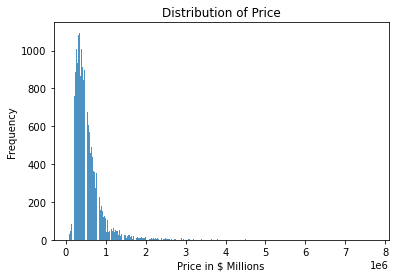

In [15]:
#From Eldrich
plt.hist(x = data.price, bins = 'auto', alpha = 0.80, rwidth= .85)
plt.xlabel('Price in $ Millions')
plt.ylabel('Frequency')
plt.title('Distribution of Price');

* Price is fairly normally distributed, with a mean of about $500,000. 

In [16]:
# From Eldrich
def boxit(DataFrame, independent, dependent):
    """ Returns boxplot of chosen independent column and dependent column.
        
        Parameters:
        DataFrame: A Pandas DataFrame
        Independent: Column or feature from dataframe to be chosen as the predictor variable
        Dependent: Column to be predicted
        """
    ax = sns.boxplot(data = DataFrame, x = independent, y = dependent)
    return

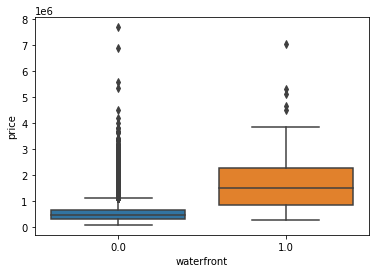

In [17]:
boxit(data, 'waterfront', 'price')

* The interquartile range of waterfront properties (marked as 1.0 on boxplot) is larger thus the range of price for the middle half of waterfront properties is also larger

* The upper quartile of waterfront properties is more expensive while its lower quartile is around the same price as the upper quartile of non-waterfront properties

* Both maximum and minimum values (denoted by the boxplot's whiskers) are higher respectively for waterfront properties

* Non-waterfront properties have extreme outliers

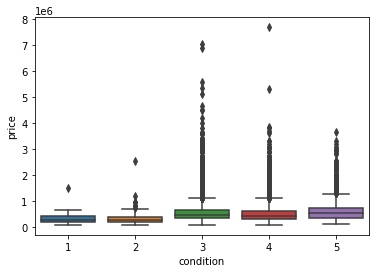

In [18]:
boxit(data, 'condition', 'price')

* Properties' condition don't appear to show high correlation with price, with each condition posting relatively similar price ranges. 
* It does appear that outliers peak at condition-3 

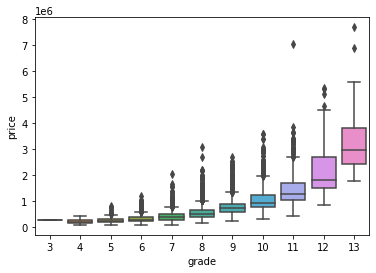

In [19]:
boxit(data, 'grade', 'price')

* There is a rising pattern in prices as the grade of properties go up; this can certainly be an indicator of a linear relationship between property grade and price. 

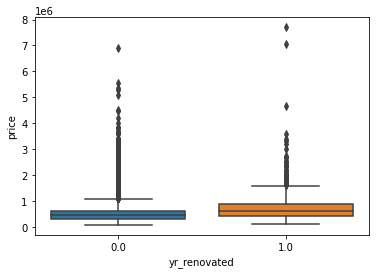

In [20]:
# Since the majority of homes have not been renovated, replace nulls with
# value 0 and change values to either 1 or 0. 
data.yr_renovated.fillna(value = 0, inplace = True)
data.loc[(data.yr_renovated > 0), 'yr_renovated'] = 1
boxit(data, 'yr_renovated', 'price')

* Being renovated does not seem to have an outsize impact on price. 

In [21]:
# Taking a closer look at our target variable, sales price
bins=[0,100000,300000,500000,900000,2000000,7000000]
choices =['$0-$100k','$100k-$300k','$400k-$500k','$600k-$900k','$1mlln-$2mlln','$2mlln-$7mlln']
data['price_range']=pd.cut(data['price'],bins=bins,labels=choices)

In [22]:
#Convert "date" column into datetime format
data['date']= pd.to_datetime(data['date'])
# Grab year from date column
data['year_of_sale'] = pd.DatetimeIndex(data['date']).year
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_range,year_of_sale
0,7129300520,2014-10-13,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650,$100k-$300k,2014
1,6414100192,2014-12-09,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,1.00,98125,47.72,-122.32,1690,7639,$600k-$900k,2014
2,5631500400,2015-02-25,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,0.00,98028,47.74,-122.23,2720,8062,$100k-$300k,2015
3,2487200875,2014-12-09,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000,$600k-$900k,2014
4,1954400510,2015-02-18,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503,$600k-$900k,2015


In [23]:
data['year_of_sale'].value_counts()

2014    14622
2015     6975
Name: year_of_sale, dtype: int64

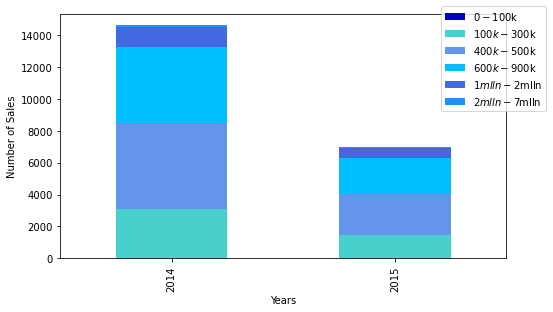

In [24]:
plt.rcParams["figure.figsize"] = [8,4.5]
ax = data.groupby(['year_of_sale','price_range']).size().unstack().plot.bar(stacked=True, color=['mediumblue','mediumturquoise','cornflowerblue','deepskyblue','royalblue','dodgerblue'])
horiz_offset = 1
vert_offset = 1
ax.set_xlabel('Years')
ax.set_ylabel('Number of Sales')
ax.legend(bbox_to_anchor=(1.1, 1.05));

* The supply of homes (i.e. number of sales) decreased by almost half from 2014 to 2015 
* The the proportion of homes sold within each price range has remained relatively constant from year to year despite the decrease in total overall sales; this stability is helpful for teasing out strong features for the particularly high-value homes. 

In [25]:
def conv(year):
  return data[data['year_of_sale']==year].groupby('price_range').size()
perc_total = [x/sum(x)*100 for x in [conv(2014),conv(2015)]]
year_names = list(range(2014,2016))
housing_df = pd.DataFrame(perc_total, index= year_names)

Function courtesy of [Emmanuel Sibanda](https://hackernoon.com/predicting-the-price-of-houses-in-brooklyn-using-python-1abd7997083b)

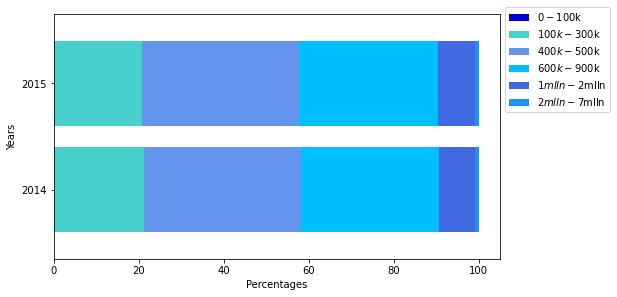

In [26]:
plt.rcParams["figure.figsize"] = [8,4.5]
ax_two = housing_df.plot(kind='barh', stacked=True, color=['mediumblue','mediumturquoise','cornflowerblue','deepskyblue','royalblue','dodgerblue'], width=0.8)
horiz_offset = 1
vert_offset = 1
ax_two.set_xlabel('Percentages')
ax_two.set_ylabel('Years')
ax_two.legend(bbox_to_anchor=(1.0, 1.05));

* Most homes sold are within the $400,000 - $500,000 range, with a sizeable chunk in the $600,000-$900,000 range 

# 3. Data Cleaning

In [27]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_range,year_of_sale
0,7129300520,2014-10-13,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650,$100k-$300k,2014
1,6414100192,2014-12-09,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,1.00,98125,47.72,-122.32,1690,7639,$600k-$900k,2014
2,5631500400,2015-02-25,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,0.00,98028,47.74,-122.23,2720,8062,$100k-$300k,2015
3,2487200875,2014-12-09,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000,$600k-$900k,2014
4,1954400510,2015-02-18,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503,$600k-$900k,2015


In [28]:
# Dropping some columns that look less promising
# df.drop(['B', 'C'], axis=1, inplace=True) <-- to make the change the df itself , use inplace=True
to_drop = ['id', 'date', 'view', 'sqft_above', 'lat', 'long', 'sqft_lot15', 'sqft_basement', 'waterfront','yr_renovated', 'price_range', 'year_of_sale']

In [29]:
data.drop(to_drop, axis = 1, inplace = True)

In [30]:
data.shape

(21597, 11)

In [31]:
# Drop one really obvious outlier that was clearly a data entry error
mask = data.loc[data['bedrooms']>20].index
data.drop(mask, axis = 0, inplace=True)

In [32]:
data.shape

(21596, 11)

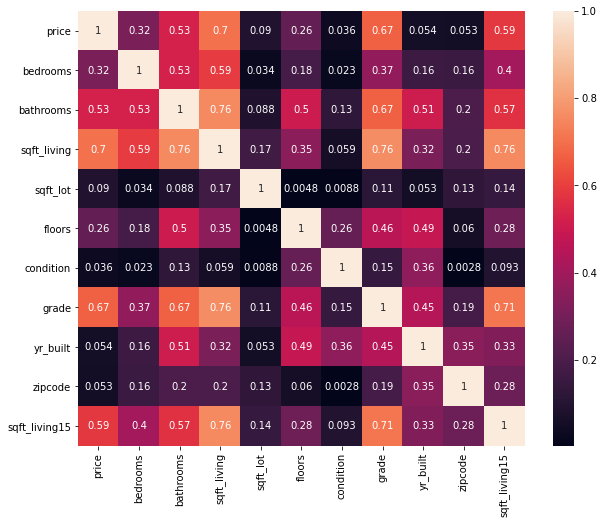

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr().abs(), annot=True)
plt.show()

In [34]:
#sns.pairplot(data)

# 3. Split Data into Training and Test Sets

In [35]:
# divide dataset into X predictors and y target
X = data.drop(['price'], axis=1)
y = data[['price']]

# split data 80% training and 20% test w/ random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [36]:
len(X_test) + len(X_train) == len(X)

True

In [37]:
X_train.shape

(17276, 10)

In [38]:
X_test.shape

(4320, 10)

In [39]:
# Instantiate a scaler
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()

In [41]:
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. First Substandard Model

In [42]:
# Instantiate a linear regression model
lr = LinearRegression()

In [43]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [44]:
from sklearn.metrics import r2_score, mean_absolute_error

In [45]:
# Evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")

Training Scores:
R2: 0.6237661706892493
Mean Absolute Error: 144945.57636353228
---
Testing Scores:
R2: 0.6052645946329722
Mean Absolute Error: 145254.48398036984


* Fine, but not great
* Training higher than testing, which is an indication of underfitting 
* MAE = $145,254 indicates average error in predicting a home price, which is almost 2x more than the minimum in the dataset

# 5. Model 1 (Zip Code Engineering)

To engineer a location feature, I chose to use the median price for each individual zip code. Zip code is a categorical feature, which is oftentimes dealt with through one-hot encoding. However, given the many unique zip codes present in the dataset (70), I was concerned that adding 70 additional variables to my dataset would increase the dimensionality to a point that decreases the reliability of the model. 

Therefore, using the median price for each zip code seemed like an appropriate proxy and could be a reasonably good predictor of future home prices for that area. 

In [46]:
traindf = X_train.copy()

In [47]:
traindf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15
6243,4,2.00,1440,4855,2.00,4,7,1972,98144,1300
8986,3,1.75,1430,9857,1.00,4,7,1980,98045,1310
9419,4,2.75,3120,5000,2.00,3,9,2010,98074,3200
10155,4,2.50,2060,6958,1.00,3,7,1974,98034,1760
10436,3,2.00,2500,4080,1.50,5,7,1922,98103,1550


In [48]:
traindf['price'] = y_train
traindf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15,price
6243,4,2.00,1440,4855,2.00,4,7,1972,98144,1300,"332,500.00"
8986,3,1.75,1430,9857,1.00,4,7,1980,98045,1310,"390,000.00"
9419,4,2.75,3120,5000,2.00,3,9,2010,98074,3200,"800,000.00"
10155,4,2.50,2060,6958,1.00,3,7,1974,98034,1760,"462,000.00"
10436,3,2.00,2500,4080,1.50,5,7,1922,98103,1550,"695,000.00"


In [49]:
traindf.shape

(17276, 11)

In [50]:
traindf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15,price
6243,4,2.00,1440,4855,2.00,4,7,1972,98144,1300,"332,500.00"
8986,3,1.75,1430,9857,1.00,4,7,1980,98045,1310,"390,000.00"
9419,4,2.75,3120,5000,2.00,3,9,2010,98074,3200,"800,000.00"
10155,4,2.50,2060,6958,1.00,3,7,1974,98034,1760,"462,000.00"
10436,3,2.00,2500,4080,1.50,5,7,1922,98103,1550,"695,000.00"


In [51]:
testdf = X_test.copy()

In [52]:
testdf['price'] = y_test

In [53]:
testdf.shape

(4320, 11)

In [54]:
testdf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15,price
3686,3,0.75,850,8573,1.00,3,6,1945,98146,850,"132,500.00"
10247,3,1.00,1510,6083,1.00,4,6,1940,98115,1510,"415,000.00"
4037,4,2.25,1790,42000,1.00,3,7,1983,98045,2060,"494,000.00"
3437,2,1.50,1140,2500,1.00,3,7,1988,98106,1500,"355,000.00"
19291,3,1.00,1500,3920,1.00,3,7,1947,98107,1640,"606,000.00"


In [55]:
# Replace all values in zipcode column with median sale price 
# 1. Group all zipcodes together with median average sale price 
# 2. Replace any zipcode value corresponding to a particular zip code 
# with its median average sales price 
zip_group = traindf.groupby(['zipcode']).median()

In [56]:
test_zip_group = testdf.groupby(['zipcode']).median()

In [57]:
zip_group.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price
zipcode,,,,,,,,,,
98001,3.00,2.12,"1,875.00","9,303.50",1.00,3.00,7.00,"1,981.00","1,710.00","264,750.00"
98002,3.00,1.75,"1,575.00","7,279.00",1.00,4.00,7.00,"1,967.00","1,420.00","235,000.00"
98003,3.00,2.00,"1,730.00","8,900.00",1.00,3.00,7.00,"1,975.00","1,755.00","265,000.00"
98004,4.00,2.50,"2,620.00","11,125.00",1.00,3.00,8.00,"1,964.00","2,510.00","1,100,000.00"
98005,4.00,2.25,"2,500.00","12,815.50",1.00,4.00,8.00,"1,967.00","2,490.00","779,000.00"


In [58]:
test_zip_group.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price
zipcode,,,,,,,,,,
98001,3.00,2.00,"1,620.00","9,135.00",1.00,3.00,7.00,"1,984.00","1,610.00","246,900.00"
98002,3.00,2.00,"1,550.00","7,314.00",1.00,4.00,7.00,"1,961.00","1,340.00","235,000.00"
98003,3.00,2.25,"2,020.00","8,620.00",1.00,3.00,7.00,"1,977.00","1,840.00","271,500.00"
98004,4.00,2.50,"2,920.00","10,929.00",1.50,3.00,9.00,"1,966.00","2,600.00","1,430,000.00"
98005,4.00,2.50,"2,605.00","10,769.50",1.00,4.00,8.00,"1,967.50","2,260.00","742,250.00"


In [59]:
zip_group.shape

(70, 10)

In [60]:
zip_group = zip_group['price'].reset_index()

In [61]:
zip_group.head()

,zipcode,price
0,98001,"264,750.00"
1,98002,"235,000.00"
2,98003,"265,000.00"
3,98004,"1,100,000.00"
4,98005,"779,000.00"


In [62]:
# Join zip_group with train df
joined_zip = pd.merge(zip_group, traindf, how = 'inner', on='zipcode').reset_index()
joined_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [63]:
# Join zip_group with test df 
joined_test_zip = pd.merge(zip_group, testdf, how='inner', on='zipcode').reset_index()
joined_test_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,1,98001,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,2,98001,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,3,98001,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,4,98001,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [64]:
joined_test_zip.shape

(4320, 13)

##  Visualizing Median Price per Zip Code

In [65]:
import folium
import json
import geopandas as gpd
import branca.colormap as cm
#from shapely.geometry import shape

In [66]:
# Initiate folium map
#Seattle_map = folium.Map(location = [47.608013,-122.335167], zoom_start = 10)
#zipcodes_json = folium.GeoJson("data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson", name="geojson").add_to(Seattle_map)
#Seattle_map

[Link to geojson file](https://www5.kingcounty.gov/sdc/Metadata.aspx?Layer=zipcode) from King County GIS Database

In [67]:
#zipcodes_gdf = gpd.read_file("data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson", name="geojson")

In [68]:
# Load GeoJSON
with open('data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson', 'r') as jsonSea:
    jsdata = json.load(jsonSea)
tmp = jsdata

In [69]:
# Load fresh version of original data to grab zipcodes 
orig_df = pd.read_csv('data/kc_house_data.csv')

In [70]:
zip_group.shape

(70, 2)

In [71]:
zipcodes_indf = []

for x in orig_df['zipcode']:
    if x not in zipcodes_indf:
        zipcodes_indf.append(x)

In [72]:
len(zipcodes_indf)

70

This method of cleaning the JSON and saving it as a new file is courtesy of [Jonny Hofmeister](https://github.com/jonnyhof). 

In [73]:
# Parse the GeoJSON for zipcodes that are in our dataset. 
geozips = []

for i in range(len(tmp['features'])):
    if int(tmp['features'][i]['properties']['ZIPCODE']) in zipcodes_indf:
        geozips.append(tmp['features'][i])

In [74]:
len(geozips)

74

In [75]:
# We have four duplicate zipcodes. 
zips = []
for i in geozips:
    zips.append(i['properties']['ZIPCODE'])

In [76]:
# Use pandas to easily find duplicates. 
zips = pd.DataFrame(zips)
zips.value_counts().head()

98072    2
98077    2
98092    2
98022    2
98199    1
dtype: int64

In [77]:
# Find index of duplicates to remove them. 
for i in geozips:
    if i['properties']['ZIPCODE'] in ['98072', '98077', '98092', '98022']:
        print(str(geozips.index(i))+' is an index of '+i['properties']['ZIPCODE'])

13 is an index of 98022
14 is an index of 98022
25 is an index of 98092
41 is an index of 98072
42 is an index of 98072
46 is an index of 98077
47 is an index of 98077
48 is an index of 98092


In [78]:
# Make list of indices to remove them. 
to_del = [14, 41, 46, 48]
for d in to_del: 
    del geozips[d]

In [79]:
# Sanity check
len(geozips)

70

In [80]:
# Creating a new JSON object
new_json = dict.fromkeys(['type', 'features', 'zipcode'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

In [81]:
# Same GeoJSON object as an updated file. 

open('data/updated-file.json', 'w').write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

11110915

In [82]:
# Check coordinates reference system of dataframe
#print(zipcodes_gdf.crs)

In [83]:
# zipcodes_gdf.head()

In [84]:
# # Drop unnecessary columns from geopandas df
# zipcodes_gdf = zipcodes_gdf.drop(['OBJECTID', 'ZIPCODE', 'COUNTY', 'ZIP_TYPE', 'Shape_Length', 'Shape_Area'], axis=1)
# zipcodes_gdf.head()

In [85]:
# # Rename ZIP column 
# zipcodes_gdf = zipcodes_gdf.rename(columns={"ZIP": "zipcode"})

In [86]:
# zipcodes_gdf.plot(figsize=(6, 6))
# plt.show()

In [87]:
# Read in cleaned GeoJSON file as a Geopandas dataframe 
loc_data = gpd.read_file('data/updated-file.json')
loc_data.head()

,COUNTY,OBJECTID,Shape_Area,Shape_Length,ZIP,ZIPCODE,ZIP_TYPE,geometry
0,033,1,"228,012,907.12","117,508.23",98031,98031,Standard,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."
1,033,2,"482,675,358.83","166,737.67",98032,98032,Standard,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436..."
2,033,3,"200,095,361.22","94,409.54",98030,98030,Standard,"POLYGON ((-122.21006 47.38692, -122.21060 47.3..."
3,033,4,"277,424,676.85","111,093.72",98029,98029,Standard,"POLYGON ((-121.97642 47.58430, -121.97640 47.5..."
4,033,5,"199,653,136.52","71,488.23",98028,98028,Standard,"POLYGON ((-122.22788 47.76909, -122.22777 47.7..."


In [88]:
#All we need from the GeoJSON is the location data tied to zipcode, so drop all other columns
geos = loc_data[['ZIPCODE' , 'geometry']]
geos.head()

,ZIPCODE,geometry
0,98031,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."
1,98032,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436..."
2,98030,"POLYGON ((-122.21006 47.38692, -122.21060 47.3..."
3,98029,"POLYGON ((-121.97642 47.58430, -121.97640 47.5..."
4,98028,"POLYGON ((-122.22788 47.76909, -122.22777 47.7..."


In [89]:
# Change zipcode colum in zipcodes/price df to str so it can key on the json zipcode column
zip_group['zipcode'] = zip_group['zipcode'].astype(str)

In [90]:
geos.dtypes

ZIPCODE       object
geometry    geometry
dtype: object

In [91]:
zip_group.dtypes

zipcode     object
price      float64
dtype: object

In [92]:
# Join zipcode/median price df with geos df (that has location data) 
geos = geos.merge(zip_group, left_on = 'ZIPCODE', right_on='zipcode', how='inner')
geos.head()

,ZIPCODE,geometry,zipcode,price
0,98031,"POLYGON ((-122.21842 47.43750, -122.21896 47.4...",98031,"289,950.00"
1,98032,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436...",98032,"250,000.00"
2,98030,"POLYGON ((-122.21006 47.38692, -122.21060 47.3...",98030,"285,000.00"
3,98029,"POLYGON ((-121.97642 47.58430, -121.97640 47.5...",98029,"572,750.00"
4,98028,"POLYGON ((-122.22788 47.76909, -122.22777 47.7...",98028,"446,000.00"


In [93]:
geos.drop(['zipcode'],axis = 1, inplace=True)

In [94]:
geos.head()

,ZIPCODE,geometry,price
0,98031,"POLYGON ((-122.21842 47.43750, -122.21896 47.4...","289,950.00"
1,98032,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436...","250,000.00"
2,98030,"POLYGON ((-122.21006 47.38692, -122.21060 47.3...","285,000.00"
3,98029,"POLYGON ((-121.97642 47.58430, -121.97640 47.5...","572,750.00"
4,98028,"POLYGON ((-122.22788 47.76909, -122.22777 47.7...","446,000.00"


In [95]:
#price_and_zip.dtypes

In [96]:
#len(price_and_zip)

In [97]:
# We have four duplicate zipcodes in our merged dataframe. 
#price_and_zip['zipcode'].value_counts().head()

In [98]:
# I examined these duplicates in the dataframe and noticed that the dupes have slightly different lat/lons. 
# I will keep the first instance for now and drop the second; if that causes trouble for my map, 
# I will go back and do the opposite. 
# price_and_zip = price_and_zip.drop_duplicates(subset=['zipcode'], keep='first')
# len(price_and_zip)

In [99]:
# Now that our dataframe is cleaned, we need 

In [100]:
# price_and_zip['zipcode'] = price_and_zip['zipcode'].astype(str)

In [101]:
# price_and_zip.dtypes

In [102]:
# Overlay the boundaries of zip code areas on folium map with zipcode as popup 
# for _, r in price_and_zip.iterrows():
#     #without simplifying the representation of each borough, the map might not be displayed
#     #sim_geo = gpd.GeoSeries(r['geometry'])
#     sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j,
#                            style_function=lambda x: {'fillColor': 'yellow'})
#     folium.Popup(r['zipcode']).add_to(geo_j)
#     geo_j.add_to(Seattle_map)

# Seattle_map

In [103]:

# for zip in zipcodes_json:
#     d['the_geom'] = shape(d['the_geom'])

# gdf = gpd.GeoDataFrame(data).set_geometry('the_geom')
# gdf.head()

# study_area = json.loads("""
#  {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[36.394272, -18.626726], [36.394272, -18.558391], [36.489716, -18.558391], [36.489716, -18.626726], [36.394272, -18.626726]]]}}]}
# """)
# gdf = gpd.GeoDataFrame.from_features(study_area["features"])
# print(gdf.head())

In [137]:
# Visualize relationship between zip code and median house price 

# Initiate folium map 
Seattle_map = folium.Map(location = [47.608013,-122.335167], zoom_start = 10)

# Change map to grayed-out version 
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(Seattle_map)

# Create colormap 
colormap = cm.linear.YlGnBu_09.to_step(data=geos['price'], method='quant', quantiles=[0,0.1,0.75,0.9,0.98,1])
colormap

# Creating a choropleth map 
folium.Choropleth(
            geo_data = geos,
            fill_opacity = 0.7,
            line_opacity = 0.2,
            data = geos,
            #refers to which key within json file to map zip to
            key_on = 'feature.properties.ZIPCODE',
            # first element is location, second element is price
            columns = ['ZIPCODE', 'price'],
            # change the colormap to whatever you want, the diverging maps work well for price
            fill_color = 'YlGnBu',
            legend_name = 'Price'
).add_to(Seattle_map)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

NIL = folium.features.GeoJson(
    data = geos,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['ZIPCODE', 'price'],
        aliases=['Zipcode', 'Median Price'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
Seattle_map.add_child(NIL)
Seattle_map.keep_in_front(NIL)

folium.LayerControl().add_to(Seattle_map)
#Seattle_map.save('data/zipcode_price_map.html')

#Seattle_map

In [105]:
from IPython.display import IFrame

IFrame(src='data/zipcode_price_map.html', width=950, height=600)

## Back to Modeling

In [106]:
# Joined_zip is the training data for iteration 2
joined_zip.shape

(17276, 13)

In [107]:
joined_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [108]:
# Rename price_x column as median price per zipcode 
joined_zip = joined_zip.rename(columns={"price_x": "med_price_for_zip"})
joined_zip.head()

,index,zipcode,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [109]:
# Drop zipcode and index columns
trained_zip = joined_zip.drop(['index', 'zipcode'], axis=1)
trained_zip.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [110]:
# Do the same with test data
test_zip = joined_test_zip.rename(columns={"price_x": "med_price_for_zip"})
test_zip.head()

,index,zipcode,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,1,98001,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,2,98001,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,3,98001,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,4,98001,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [111]:
test_zip = joined_test_zip.drop(['index', 'zipcode'], axis=1)
test_zip.head()

,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [112]:
# Divide data in to x predictors and y targets 
# divide dataset into X predictors and y target
X_test_zip = test_zip.drop(['price_y'], axis=1)
y_test_zip = test_zip[['price_y']]

X_trained_zip = trained_zip.drop(['price_y'], axis=1)
y_trained_zip = trained_zip[['price_y']]

In [113]:
# Train our scaler on training data, then fit to testing
X_trained_zip_scaled = scaler.fit_transform(X_trained_zip)
X_test_zip_scaled = scaler.transform(X_test_zip)

In [114]:
# Fit our model on our scaled data
lr.fit(X_trained_zip_scaled, y_trained_zip)

LinearRegression()

In [115]:
# Evaluate
y_train_pred = lr.predict(X_trained_zip_scaled)
y_test_pred = lr.predict(X_test_zip_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_trained_zip, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_trained_zip, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test_zip, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_zip, y_test_pred)}")

Training Scores:
R2: 0.7363291865117058
Mean Absolute Error: 112465.36617955659
---
Testing Scores:
R2: 0.7229711101210686
Mean Absolute Error: 111841.20169660255


* A little better than our FSM
* Training now higher than testing, which is an indication of overfitting 
* MAE went down slightly which is a good sign
* MAE a little less than half of one standard deviation

# 6. Checking Some Assumptions

In [116]:
# Check for linearity and multicollinearity with sns pairplot
#sns.pairplot(trained_zip)

* No x variables look especially multicollinear... 
* Squareft_living15, sqft_living and bathrooms look to be the most linearly related

In [117]:
trained_zip.corr()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
med_price_for_zip,1.00,0.12,0.24,0.31,-0.03,0.15,0.04,0.38,-0.04,0.35,0.64
bedrooms,0.12,1.00,0.53,0.59,0.04,0.18,0.02,0.36,0.16,0.40,0.32
bathrooms,0.24,0.53,1.00,0.76,0.08,0.50,-0.13,0.66,0.50,0.57,0.53
sqft_living,0.31,0.59,0.76,1.00,0.17,0.35,-0.06,0.76,0.31,0.76,0.70
sqft_lot,-0.03,0.04,0.08,0.17,1.00,-0.01,-0.01,0.11,0.05,0.15,0.09
floors,0.15,0.18,0.50,0.35,-0.01,1.00,-0.26,0.46,0.48,0.28,0.26
condition,0.04,0.02,-0.13,-0.06,-0.01,-0.26,1.00,-0.14,-0.36,-0.09,0.04
grade,0.38,0.36,0.66,0.76,0.11,0.46,-0.14,1.00,0.44,0.72,0.67
yr_built,-0.04,0.16,0.50,0.31,0.05,0.48,-0.36,0.44,1.00,0.33,0.05
sqft_living15,0.35,0.40,0.57,0.76,0.15,0.28,-0.09,0.72,0.33,1.00,0.59


* Could probably drop some columns that aren't doing as much for us - yr_built and condition, for example

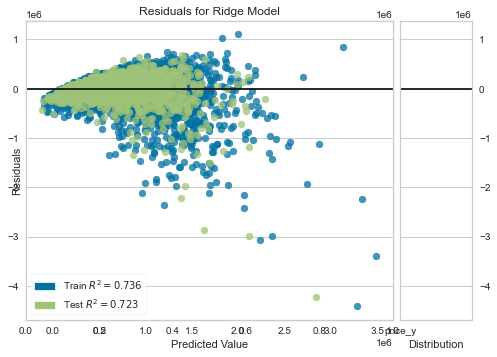

In [143]:
# Checking for last 3 linear assumptions - 
# errors are normally distributed, errors are homoskedastic, errors are not correlated
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

model = Ridge()
visualizer = ResidualsPlot(model)

visualizer = ResidualsPlot(model, hist=True, qqplot=False)
visualizer.fit(X_trained_zip_scaled, y_trained_zip)  # Fit the training data to the visualizer
visualizer.score(X_test_zip_scaled, y_test_zip)  # Evaluate the model on the test data
visualizer.show();# Finalize and render the figure

* Errors are slightly skewed negative 
* Errors are heteroskedastic (cone shaped pattern) -> potential fix: variable transformation (log)

# 7. Model 2 (Log-Transform)

In [119]:
trained_zip.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [120]:
trained_zip.astype('int64').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17276 entries, 0 to 17275
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   med_price_for_zip  17276 non-null  int64
 1   bedrooms           17276 non-null  int64
 2   bathrooms          17276 non-null  int64
 3   sqft_living        17276 non-null  int64
 4   sqft_lot           17276 non-null  int64
 5   floors             17276 non-null  int64
 6   condition          17276 non-null  int64
 7   grade              17276 non-null  int64
 8   yr_built           17276 non-null  int64
 9   sqft_living15      17276 non-null  int64
 10  price_y            17276 non-null  int64
dtypes: int64(11)
memory usage: 1.4 MB


In [121]:
# Transforming non-normal features 
non_normal = ['med_price_for_zip', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','condition', 'yr_built', 'sqft_living15', 'price_y']

In [122]:
for feat in non_normal:
    trained_zip[feat] = trained_zip[feat].map(lambda x: np.log(x))
#pd.plotting.scatter_matrix(x_cols, figsize=(10,12));

In [123]:
# Checking for infinity values
ds = trained_zip.isin([np.inf, -np.inf]).values.sum()
print(ds)

0


In [124]:
trained_zip.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,12.49,0.69,0.56,7.11,9.66,0.00,1.10,6,7.59,7.32,12.28
1,12.49,1.39,0.92,7.78,8.43,0.69,1.10,8,7.60,7.71,12.54
2,12.49,1.61,0.56,7.58,9.07,0.00,1.10,7,7.58,7.41,12.52
3,12.49,1.10,0.00,7.24,9.68,0.00,1.39,6,7.58,7.26,12.35
4,12.49,1.39,0.56,7.49,9.39,0.00,1.61,6,7.57,7.35,12.21


In [125]:
non_normal_test = ['price_x', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','condition', 'yr_built', 'sqft_living15', 'price_y']

In [126]:
for feat in non_normal_test:
    test_zip[feat] = test_zip[feat].map(lambda x: np.log(x))
#pd.plotting.scatter_matrix(x_cols_test, figsize=(10,12));

In [127]:
test_zip.head()

,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,12.49,1.10,0.56,7.68,9.21,0.00,1.39,7,7.59,7.63,12.47
1,12.49,1.10,0.00,7.05,8.78,0.41,1.39,5,7.57,7.00,12.05
2,12.49,1.10,0.69,6.96,9.81,0.00,1.39,7,7.58,7.43,12.43
3,12.49,1.61,0.92,7.79,8.87,0.69,1.10,8,7.60,7.48,12.51
4,12.49,1.10,0.81,7.51,9.34,0.00,1.10,7,7.58,7.71,12.35


In [128]:
# Divide data in to x predictors and y targets 
X_test_2 = test_zip.drop(['price_y'], axis=1)
y_test_2 = test_zip[['price_y']]

X_train_2 = trained_zip.drop(['price_y'], axis=1)
y_train_2 = trained_zip[['price_y']]

In [129]:
# Train our scaler on training data, then fit to testing
X_train_2_scaled = scaler.fit_transform(X_train_2)
X_test_2_scaled = scaler.transform(X_test_2)

In [130]:
# Fit our model on our scaled data
lr.fit(X_train_2_scaled, y_train_2)

LinearRegression()

* Some overfitting

In [147]:
#now to print MAE in terms of $$ and not logged price, function provided by Lindsey and is imported from py file
fn.print_metrics(y_train_2, y_train_2_pred, y_test_2, y_test_2_pred, log=True)

Training Scores
----------
R2: 0.8267
RMSE: 174228.1287
MAE: 94313.9688

**********
Testing Scores
----------
R2: 0.8228
RMSE: 180291.1385
MAE: 93459.3011


In [155]:
model_two = sm.OLS(y_train_2, sm.add_constant(X_train_2_scaled)).fit()

model_two.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     8237.
Date:                Sun, 27 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:16:23   Log-Likelihood:                 1675.7
No. Observations:               17276   AIC:                            -3329.
Df Residuals:                   17265   BIC:                            -3244.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.0493      0.002   7807.837      0.000      13.046      13.053
price_x           0.2553      0.002    131.703      0.000       0.251       0.259
bedrooms         -0.0313      0.002    -13.799      0.000      -0.036      -0.027
bathrooms         0.0345      0.003     11.414      0.000       0.029       0.040
sqft_living       0.1803      0.004     45.630      0.000       0.173       0.188
sqft_lot         -0.0024      0.002     -1.196      0.232      -0.006       0.002
floors            0.0183      0.002      8.287      0.000       0.014       0.023
condition         0.0201      0.002     11.114      0.000       0.017       0.024
grade             0.1536      0.003     52.391      0.000       0.148       0.159
yr_built         -0.1018      0.002    -44.771      0.000      -0.106      -0.097
sqft_living15     0.0235      0.003      8.447      0.000       0.018       0.029
==============================================================================
Omnibus:                     1192.549   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3699.195
Skew:                           0.342   Prob(JB):                         0.00
Kurtosis:                       5.161   Cond. No.                         5.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On the training data, about 83% of the data fits the regression model. The fact that the training r-squared is higher than the testing r-squared indicates slight overfitting. The p-values for all but one of the predictors (sqft_lot) seem to be significant. The Root Mean Squared Error is about half of the standard deviation, while the Mean Absolute Error is about a quarter of the standard deviation (lower than what it was in the first model, but still a substantial amount of error in the context of home prices). 

# 8. Checking Assumptions, Again

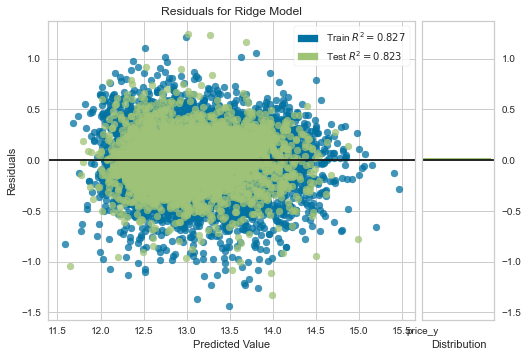

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [132]:
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_2_scaled, y_train_2)  # Fit the training data to the visualizer
visualizer.score(X_test_2_scaled, y_test_2)  # Evaluate the model on the test data
visualizer.show()           

In [133]:
X_train_2_scaled = pd.DataFrame(X_train_2_scaled, columns = ['price_x', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'condition', 'grade', 'yr_built', 'sqft_living15'])

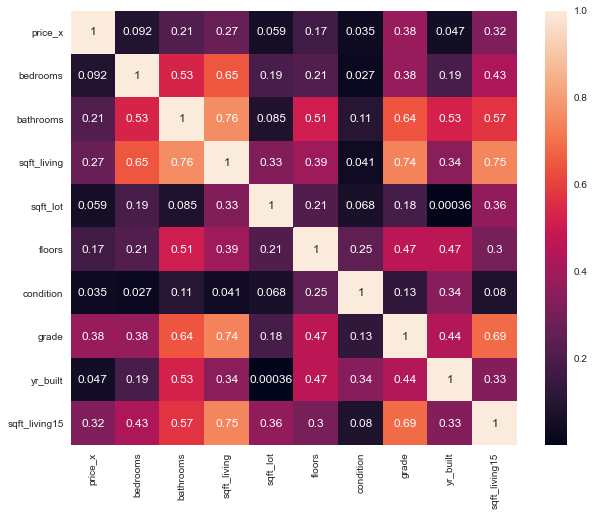

In [134]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train_2_scaled.corr().abs(), annot=True)
plt.show()

* sqft_living and bathroms may be multicollinear at .76 
* sqft_living and sqft_living15 may be multicollinear at .75
* sqft_living and grade may be multicollinear at .74

Since we already tested for multicollinearity at the beginning of the analysis, we will focus the multicollinearity check for the variables I flagged above. 

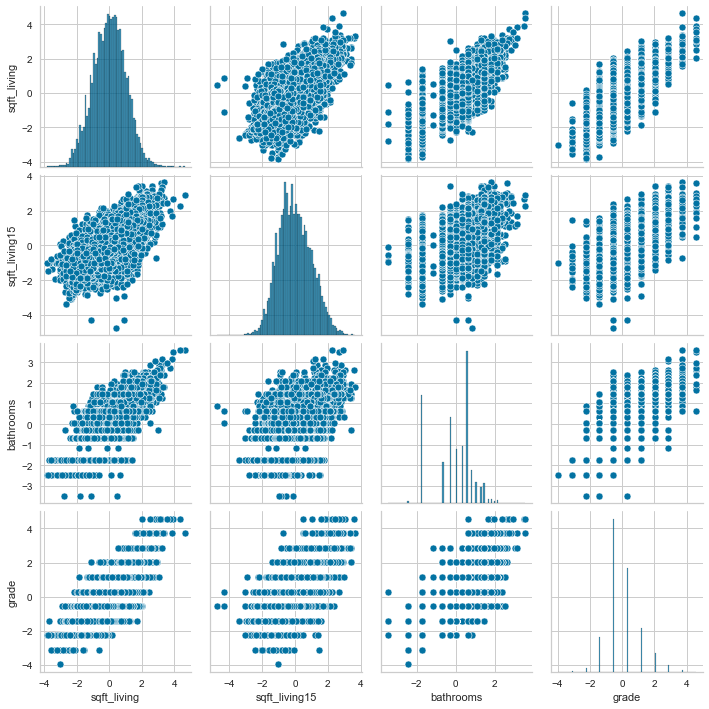

In [161]:
sns.pairplot(
    X_train_2_scaled,
    x_vars=["sqft_living", "sqft_living15", "bathrooms","grade"],
    y_vars=["sqft_living", "sqft_living15", "bathrooms","grade"],
);

None of these appear to be extreme cases of multicollinearity; however, there is evidence of linear relationships amongst many of these variables. Interestingly, grade and sqft_living seem to have a positive linear correlation. In addition, sqft_living and sqft_living 15 appear to have higher multicollinearity relative to the rest of the variables in these plots. 

# 9. Model 3 (Add combined square footage feature) 

For this project, we have changed only one element at a time so that the effects on the model can be easily tracked. Though there are several potential multicollinear relationships above, one of the easiest things to try and mitigate woul be the sqft_living and the sqft_living15 multicollinearity issue. It makes sense that a home's square footage would be closely related to the square footage of a home's neighbors, especially as you get either closer to and farther away from the Seattle city center. We can turn this column into a ratio (house size/neighbor size or "sqft_ratio") that could tell us about the size of a property relative to nearby properties. A ratio of more than 1 would tell us that the property is larger than those of the nearest 15 neighbors, while a value of less than 1 would indicate that the property is smaller than the surrounding homes. 

In [ ]:

df['sqft_lot_ratio'] = df['sqft_lot']/df['sqft_lot15']
